



## Objective:

The objective of this lab is to develop a two hidden layers MLP to perform **binary classification**.

We will use a MLP with 2 hidden layer with $n_{h1}=20$ and $n_{h2}=10$ hidden units and ```relu``` activation functions.
You will perform 1000 iterations (epochs) of SGD to find the parameters.

Note: for this lab, we do not separate the dataset into a train, validation and test part.

### Data normalization

You should normalize the data to zero mean and unit standard deviation

### Model

There are various ways to write NN model in pytorch. 

In this lab, you will write three different implementations:
- **Model A**: manually defining the parameters (W1,b1,W2,b2,W3,b3), writing the forward equations, writting the loss equation, calling the .backward() and manually updating the weights using W1.grad. You will write the loop to perform 1000 epochs.
- **Model B**: using the Sequential class of pytorch
- **Model C**: a custom torch.nn.Module class for this.

For Model B and C, you will use the ready made loss and optimization from the nn and optim packages. You can use the same code to optimize the parameters of Model B and C.

### Loss

Since we are dealing with a binary classification problem, we will use a Binary Cross Entropy loss (use ```torch.nn.BCELoss``` for Model B and C).

### Parameters update/ Optimization

For updating the parameters, we will use as optimizer a simple SGD algorithm (use ```torch.optim.SGD``` for Model B and C) with a learning rate of 0.1.

Don't forget that an optimizer is applied to a set of parameters (```my_model.parameters()``` gives the parameters of the network for Model B and C).
Once the gradients have been computed (after the backpropagation has been performed), you can perform one step of optimization (using ```optimizer.step()``` for Model B and C).

### Backward propagation

Backpropagation is automatically performed in pytorch using the ```autograd``` package. 
First, reset the gradients of all parameters (using ```optimizer.zero_grad()``` for Model B and C), then perform the backpropagation ```loss.backward()```. 



## Load the python packages

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import accuracy_score



In [0]:
def Accuracy(outputs,labels):

  _, predicted = torch.max(outputs.data, 1)
  total = labels.size(0)
  correct = (predicted == labels).sum()
  accuracy = 100 * correct / total
  return accuracy

In [0]:
print(torch.__version__)

1.1.0


## Dataset

We take the usual circle dataset from sklearn.

In [0]:
from sklearn import datasets
X, y = datasets.make_circles(n_samples=1000, noise=0.2, factor=0.5)


## Normalization

In [0]:
X -= np.mean(X, axis=0, keepdims=True) 
X /= (np.std(X, axis=0, keepdims=True) + 1e-16)

## Split between training set and test set

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
# --- Convert the numpy tensors to torch tensors

X_train, X_test, y_train, y_test=torch.from_numpy(X_train).float(),torch.from_numpy(X_test).float(),torch.from_numpy(y_train).float(),torch.from_numpy(y_test).float()

We convert the ```numpy tensors``` to ```torch tensors```. 
The difference being that the latters allows to do automatic gradient differentiation (back-propagation).

In [0]:
print("X_train.shape: {}".format(X_train.size()))
print("X_test.shape: {}".format(X_test.size()))
print("y_train.shape: {}".format(y_train.size()))
print("y_test.shape: {}".format(y_test.size()))
print("y_train.shape: {}".format(y_train.size()))
print("y_test.shape: {}".format(y_test.size()))


X_train.shape: torch.Size([800, 2])
X_test.shape: torch.Size([200, 2])
y_train.shape: torch.Size([800])
y_test.shape: torch.Size([200])
y_train.shape: torch.Size([800])
y_test.shape: torch.Size([200])


## Definition of the hyper-parameters

In [0]:
n_in = X_train.shape[1]
n_h1 = 20
n_h2 = 10
n_out = 1

nb_epoch = 10000
alpha = 0.1

## Model 1 (writing the network equations)

Here, you will define the variables and write the equations of the network yourself (as you would do in numpy).
However you will use ```torch tensors``` instead of ```numpy array```. 

***Why ?*** because torch tensors will allows you to automatically get the gradient. You will use ```loss.backward``` to launch the backpropagation from ```loss```. Then, for all tensors you created and for which you declared ```requires_grad=True```, you will get the gradient of ```loss```with respect to this variable in the field ```.grad```. 

***Example*** ```W1 = torch.tensors(..., requires_grad=True)``` ... ```loss.backward``` will have the gradient $\frac{d Loss}{d W1}$in ```W1.grad```.

Don't forget that the weight $W_1, W_2, \cdots$ matrices should be initialized randomly with small values; while the bias vectors $b_1, b_2, \cdots$can be initialized to zero.

In [0]:
# --- We first initialize the variables of the network (W1, b1, ...)

W1 = Variable(torch.rand(n_in, n_h1) * 0.01, requires_grad=True)
b1 = Variable(torch.zeros(1, n_h1) * 0.01, requires_grad=True)
    
W2 = Variable(torch.rand(n_h1, n_h2) * 0.01, requires_grad=True)
b2 = Variable(torch.zeros(1, n_h2) * 0.01, requires_grad=True)

W3 = Variable(torch.rand(n_h2, n_out) * 0.01, requires_grad=True)
b3 = Variable(torch.zeros(1, n_out) * 0.01, requires_grad=True)
    

# --- We then write a function to perform the forward pass (using pytorch opertaors, not numpy operators)
# --- taking X as input and returing hat_y as output
    
def model(X):

      
        A0 = X 
        Z1 = torch.mm(A0,W1)+b1
        A1 = F.relu(Z1)
        Z2 = torch.mm(A1,W2)+b2
        A2 = F.relu(Z2)
        Z3 = torch.mm(A2,W3)+b3
        A3 = torch.sigmoid(Z3)
        hat_y = A3

       
    return hat_y

# --- We then iterate over epochs (we do not perform split into mini-batch here)
# --- For each iteration, we
# ---   a) perform the forward pass, 
# ---   b) compute the loss/cost, 
# ---   c) compute the backward pass to get the gradients of the cost w.r.t. the parameters W1, b1, ...
# ---   d) perform the update of the parameters W1, b1, ...

train_cost, train_accuracy, test_cost, test_accuracy = [], [], [], []

for num_epoch in range(0, nb_epoch):    

    # --- a) Forward pass: X (n_in, N), hat_y (n_out, N)
    hat_y = model(X_train)

    # -- We clip hat_y in order to avoid log(0)
    eps = 1e-10
    hat_y = torch.clamp(hat_y, eps, 1-eps)
    
    # --- b) Computing the loss/cost
    loss = torch.nn.BCELoss()
    cost = loss(hat_y,y_train)
      
        
    # --- Store results on train
    train_cost.append( cost )
    train_accuracy.append( accuracy_score(hat_y.data.round(), y_train.data) )
    
    

    # --- c) Backward pass
    cost.backward()
    
    # --- "with torch.no_grad()" temporarily set all the requires_grad flag to false
    with torch.no_grad():
        # --- d) perform the update of the parameters W1, b1, ...
        
            # --- the gradients dLoss/dW1 is stored in W1.grad, dLoss/db1 is stored in b1.grad, ...
          
        W1 -=(alpha*W1.grad)
        b1 -= (alpha*b1.grad)
            
        W2 -= (alpha*W2.grad)
        b2 -= (alpha*b2.grad)
            
        W3 -= (alpha*W3.grad)
        b3 -= (alpha*b3.grad)
      

    # --- We need to set to zero all gradients (otherwise they are cumulated)
    W1.grad.zero_()
    b1.grad.zero_()
    W2.grad.zero_()
    b2.grad.zero_()
    W3.grad.zero_()
    b3.grad.zero_()
    
    # --- Store results on test
    hat_y_test = model(X_test)
    test_cost.append(loss(hat_y_test,y_test))
    test_accuracy.append( accuracy_score(hat_y_test.data.round(), y_test.data) )
    
    if num_epoch % 500 == 0:
        print("epoch: {0:d} (cost: train {1:.2f} test {2:.2f}) (accuracy: train {3:.2f} test {4:.2f})".format(num_epoch, train_cost[-1], test_cost[-1], train_accuracy[-1], test_accuracy[-1]))

epoch: 0 (cost: train 0.69 test 0.69) (accuracy: train 0.50 test 0.47)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([800])) that is different to the input size (torch.Size([800, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch: 500 (cost: train 0.69 test 0.69) (accuracy: train 0.51 test 0.47)
epoch: 1000 (cost: train 0.69 test 0.69) (accuracy: train 0.51 test 0.47)
epoch: 1500 (cost: train 0.69 test 0.69) (accuracy: train 0.51 test 0.47)
epoch: 2000 (cost: train 0.69 test 0.69) (accuracy: train 0.51 test 0.47)
epoch: 2500 (cost: train 0.69 test 0.69) (accuracy: train 0.51 test 0.47)
epoch: 3000 (cost: train 0.69 test 0.69) (accuracy: train 0.51 test 0.47)
epoch: 3500 (cost: train 0.69 test 0.69) (accuracy: train 0.51 test 0.47)
epoch: 4000 (cost: train 0.69 test 0.69) (accuracy: train 0.51 test 0.47)
epoch: 4500 (cost: train 0.69 test 0.69) (accuracy: train 0.51 test 0.47)
epoch: 5000 (cost: train 0.69 test 0.69) (accuracy: train 0.51 test 0.47)
epoch: 5500 (cost: train 0.68 test 0.68) (accuracy: train 0.61 test 0.57)
epoch: 6000 (cost: train 0.31 test 0.32) (accuracy: train 0.89 test 0.91)
epoch: 6500 (cost: train 0.25 test 0.26) (accuracy: train 0.89 test 0.91)
epoch: 7000 (cost: train 0.25 test 0.25

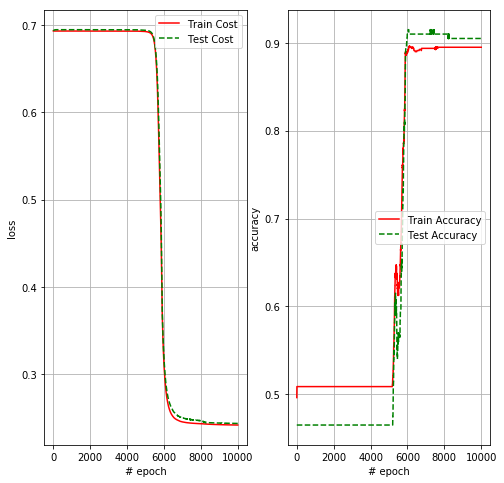

In [0]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(train_cost, 'r',label="Train Cost")
plt.plot(test_cost, 'g--',label="Test Cost")
plt.xlabel('# epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend( loc='upper right')

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r',label="Train Accuracy")
plt.plot(test_accuracy, 'g--',label="Test Accuracy")
plt.xlabel('# epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend( loc='center right')

## Model 2 (using nn.sequential)

Here, you will use the package ```torch.nn``` which comes with a predefined set of layers. The syntax is close to the one of ```keras```(```Sequential```), but differs in the fact that layers are splitted into the matrix multiplication followed by a non-linear activations (```keras```merge both using the ```Dense```layers).

The model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```. It is therefore a convenient way to write simple sequential networks.

In [0]:

    
my_model =nn.Sequential(nn.Linear(n_in, n_h1),
            nn.ReLU(True),
            nn.Linear(n_h1, n_h2),
            nn.ReLU(True),
            nn.Linear(n_h2, n_out),
            nn.Sigmoid())

   
  

## Model 3 (using a class definition)

Here, you will write the network using the recommended pytroch way; i.e. by defining a class.
This class inherit from the main class ```torch.nn.Module```.
You only need to write the ```__init__``` method and the ```forward``` method.

In object programming, the ```__init__``` method defines the attributes of your class. Since the attributes of your  network are the parameters to be trained (weights and biases), you should declare in the ```__init``` all the layers that involve parameters to be trained (mostly the ```Linear```layers which perform the matrix multiplication).

The ```forward``` method contains the code of the forward pass itself. It can of course call attributes defined in the ```__init___``` method. It is the method used when calling ```model(x)```.

As before, the model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```. 

Classes are convenient way to write more complex network than what you can do with ```nn.sequential```. Note that you can actually include a ```nn.sequential``` in your class.

In [0]:
class Net(torch.nn.Module):
    def __init__(self, n_in, n_h1, n_h2, n_out):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in, n_h1,bias=True)
        self.fc2 = nn.Linear(n_h1, n_h2,bias=True)
        self.fc3 = nn.Linear(n_h2, n_out,bias=True)
        
    def forward(self, X):
        
       
            
            A0 = X
            A1 = F.relu(self.fc1(A0))
            A2 = F.relu(self.fc2(A1))
            A3 = torch.sigmoid(self.fc3(A2))
           

        return A3


my_model = Net(n_in, n_h1, n_h2, n_out)


## Criterion and Optimization for model 2 and model 3

The code of Model 1 is self-contained, i.e. it already contains all necessary instruction to perform forawrd, loss, backward and parameter updates.

When using ```nn.sequential``` (model 2) or a class definition of the network (model 3), we still need to define 
- what we will minimize (the loss to be minimized, i.e. Binary-Cross-Entropy). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)
- how we will minimize the loss, i.e. what parameter update algorithms we will use (SGD, momentum). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)

In [0]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(my_model.parameters(), lr=alpha)
   

## Training for model 2 and 3

Having defined the network, the citerion to be minimized and the optimizer, we then perform a loop over epochs (iterations); at each step we
- compute the forward pass by passing the data to the model: ```haty = model(x)```
- compute the the loss (the criterion)
- putting at zero the gradients of all the parameters of the network (this is important since, by default, pytorch accumulate the gradients over time)
- computing the backpropagation (using as before ```.backward()```)
- performing one step of optimization (using ```.step()```)

In [0]:
train_cost, train_accuracy, test_cost, test_accuracy = [], [], [], []
for num_epoch in range(nb_epoch):
  
    hat_y = my_model(X_train) # Forward pass: Compute predicted y by passing  x to the model          
    loss = criterion(hat_y, y_train) # Compute loss 
        
        # --- Store results on train
    train_cost.append( loss )
    train_accuracy.append( accuracy_score(hat_y.data.round(), y_train.data) )
                              
        # Zero gradients, perform a backward pass, and update the weights. 
    optimizer.zero_grad() # re-init the gradients (otherwise they are cumulated)
    loss.backward() # perform back-propagation
    optimizer.step() # update the weights
     
        
        # --- Store results on test                  
    hat_y_test = my_model(X_test)                      
    test_cost.append(criterion(hat_y_test,y_test))
    test_accuracy.append( accuracy_score(hat_y_test.data.round(), y_test.data) )
   

    if num_epoch % 500 == 0:
        print("epoch: {0:d} (cost: train {1:.2f} test {2:.2f}) (accuracy: train {3:.2f} test {4:.2f})".format(num_epoch, train_cost[-1], test_cost[-1], train_accuracy[-1], test_accuracy[-1]))
        
    

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([800])) that is different to the input size (torch.Size([800, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch: 0 (cost: train 0.68 test 0.68) (accuracy: train 0.59 test 0.56)
epoch: 500 (cost: train 0.25 test 0.25) (accuracy: train 0.90 test 0.91)
epoch: 1000 (cost: train 0.24 test 0.24) (accuracy: train 0.91 test 0.90)
epoch: 1500 (cost: train 0.24 test 0.24) (accuracy: train 0.91 test 0.90)
epoch: 2000 (cost: train 0.24 test 0.24) (accuracy: train 0.91 test 0.90)
epoch: 2500 (cost: train 0.24 test 0.24) (accuracy: train 0.91 test 0.90)
epoch: 3000 (cost: train 0.24 test 0.24) (accuracy: train 0.91 test 0.90)
epoch: 3500 (cost: train 0.24 test 0.24) (accuracy: train 0.91 test 0.90)
epoch: 4000 (cost: train 0.24 test 0.24) (accuracy: train 0.91 test 0.90)
epoch: 4500 (cost: train 0.24 test 0.24) (accuracy: train 0.91 test 0.90)
epoch: 5000 (cost: train 0.24 test 0.24) (accuracy: train 0.91 test 0.90)
epoch: 5500 (cost: train 0.24 test 0.24) (accuracy: train 0.91 test 0.90)
epoch: 6000 (cost: train 0.24 test 0.24) (accuracy: train 0.91 test 0.90)
epoch: 6500 (cost: train 0.24 test 0.24) (

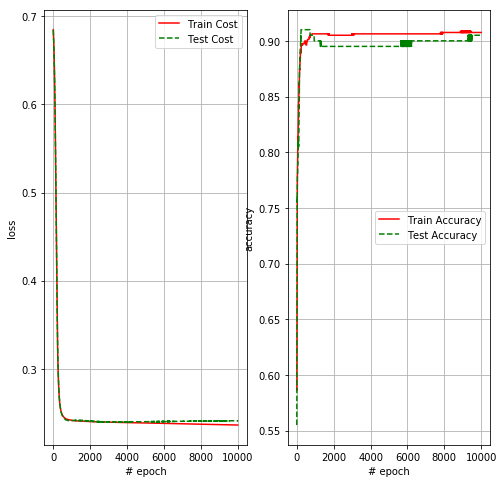

In [0]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(train_cost, 'r',label="Train Cost")
plt.plot(test_cost, 'g--',label="Test Cost")
plt.xlabel('# epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend( loc='upper right')

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r',label="Train Accuracy")
plt.plot(test_accuracy, 'g--',label="Test Accuracy")
plt.xlabel('# epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend( loc='center right')